In [1]:


import pandas as pd
from scipy import stats
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import ImageGrid
import json
import pickle
import csv



import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import random

import tensorflow as tf
from tensorflow import keras

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
try:
    for kgpu in range(len(physical_devices)):
        tf.config.experimental.set_memory_growth(physical_devices[kgpu], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass
#import psyplot.plotting.mapplot as mplot
import psyplot.project as psy
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.close_figures = False

2023-05-16 22:17:34.968650: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 22:17:37.720898: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-16 22:17:42.111936: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


[]


In [2]:
# in/out variable lists
vars_mli = ['state_t','state_q0001','state_ps','pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX']
vars_mlo = ['ptend_t','ptend_q0001','cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC','cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD']

In [3]:
# new dataset generator function
# that has new options (latlim, lonlim)

mli_mean = xr.open_dataset('./norm_factors/mli_mean.nc')
mli_min = xr.open_dataset('./norm_factors/mli_min.nc')
mli_max = xr.open_dataset('./norm_factors/mli_max.nc')
mlo_scale = xr.open_dataset('./norm_factors/mlo_scale.nc')
ne4_grid_info = xr.open_dataset('./test_data/E3SM-MMF_ne4_grid-info.orig.nc')

def load_nc_dir_with_generator_test(filelist:list, latlim=[-999,999], lonlim=[-999,999]):
    def gen():
        for file in filelist:
            
            # read mli
            ds = xr.open_dataset(file, engine='netcdf4')
            ds = ds[vars_mli]
            ds = ds.merge(ne4_grid_info[['lat','lon']])
            ds = ds.where((ds['lat']>latlim[0])*(ds['lat']<latlim[1]),drop=True)
            ds = ds.where((ds['lon']>lonlim[0])*(ds['lon']<lonlim[1]),drop=True)
            
            # read mlo
            dso = xr.open_dataset(file.replace('.mli.','.mlo.'), engine='netcdf4')
            dso = dso.merge(ne4_grid_info[['lat','lon']])
            dso = dso.where((dso['lat']>latlim[0])*(dso['lat']<latlim[1]),drop=True)
            dso = dso.where((dso['lon']>lonlim[0])*(dso['lon']<lonlim[1]),drop=True)
            
            # make mlo variales: ptend_t and ptend_q0001
            dso['ptend_t'] = (dso['state_t'] - ds['state_t'])/1200 # T tendency [K/s]
            dso['ptend_q0001'] = (dso['state_q0001'] - ds['state_q0001'])/1200 # Q tendency [kg/kg/s]
            dso = dso[vars_mlo]
            
            # normalizatoin, scaling
            ds = (ds-mli_mean)/(mli_max-mli_min)
            dso = dso*mlo_scale

            # stack
            #ds = ds.stack({'batch':{'sample','ncol'}})
            ds = ds.stack({'batch':{'ncol'}})
            ds = ds.to_stacked_array("mlvar", sample_dims=["batch"], name='mli')
            #dso = dso.stack({'batch':{'sample','ncol'}})
            dso = dso.stack({'batch':{'ncol'}})
            dso = dso.to_stacked_array("mlvar", sample_dims=["batch"], name='mlo')
            
            yield (ds.values, dso.values)

    return tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float64, tf.float64),
        output_shapes=((None,124),(None,128))
    )

In [4]:
lon = ne4_grid_info.lon.values
lat = ne4_grid_info.lat.values
area = ne4_grid_info.area.values
hyam = ne4_grid_info.hyam.values
hybm = ne4_grid_info.hybm.values
PS = ne4_grid_info.PS.values
P0 = ne4_grid_info.P0.values

In [5]:
# Function calculate the distance between two points
def convert_to_Pressure(hyam,hybm,PS,P0):
    Dimension1=hyam.shape
    Dimension2=PS.shape
    Pressure = np.zeros([Dimension1[0],Dimension2[1]])
    for i in range(Dimension2[1]):
        #temp = (P0*hyam[:] + PS[i]*hybm[:])
        #print(temp.shape)
        Pressure[:,i] = (hyam[:] + PS[0,i]*hybm[:])
    return Pressure

In [6]:
Pre = convert_to_Pressure(hyam,hybm,PS,P0)

In [35]:
Pre.shape

(60, 384)

In [7]:
# Function calculate the distance between two points
def estimate_R2(y_true,y_pred,ncol,nlev):
    Dimension=y_true.shape
    R2 = np.zeros([ncol,nlev])
    SSE = np.zeros([ncol,nlev])
    SVAR = np.zeros([ncol,nlev])
    for i in range(ncol):
        for z in range(nlev):
            y_true_temp = y_true[i::ncol,z]
            y_pred_temp = y_pred[i::ncol,z]
            y_true_temp.shape
            SSE[i,z] = np.sum((y_true_temp-y_pred_temp)**2.0)
            SVAR[i,z] = np.sum((y_true_temp-np.mean(y_true_temp))**2.0)
            R2[i,z] = 1-(SSE[i,z]/SVAR[i,z])
        
    return SSE,SVAR,R2

In [8]:
# every 10th sample
dir_test_samples = '/pscratch/sd/s/sungduk/hugging/E3SM-MMF_ne4/test/0010-03'
f_mli = sorted(glob.glob(f'{dir_test_samples}/E3SM-MMF.mli.0010-*.nc'))
#f_mli = f_mli[:1]
print(f'#files: {len(f_mli)}')
tds_test = load_nc_dir_with_generator_test(f_mli)

#files: 2232


In [9]:
# creating numpy array defeats the purpose of tf Dataset pipeline,
# but, just doing it here for quick sanity check.
work = list(tds_test.as_numpy_iterator())
x_true = np.concatenate([ work[k][0] for k in range(len(work)) ])
y_true = np.concatenate([ work[k][1] for k in range(len(work)) ])

2023-05-16 22:17:45.558350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [10]:
ncol = 384
nlev = 60

# Load best models

In [ ]:
model_paths = ""
for path in model_paths:
    model = keras.models.load_model(path)

In [11]:
model = keras.models.load_model("./saved_model/best_model_proto.h5")
#bad_model = keras.models.load_model("trythisout.h5")
y_pred = model(x_true)

In [73]:
model.summary()

Model: "Emulator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 124)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          64000       ['input[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 512)          262656      ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 128)          65664       ['dense_1[0][0]']                
                                                                                           

In [75]:
bad_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 512)               64000     
                                                                 
 dense_33 (Dense)            (None, 256)               131328    
                                                                 
 dense_34 (Dense)            (None, 128)               32896     
                                                                 
Total params: 228,224
Trainable params: 228,224
Non-trainable params: 0
_________________________________________________________________


In [12]:
T_tend_true = y_true[:,:60]
T_pred_true = y_pred[:,:60]
Q_tend_true = y_true[:,60:120]
Q_pred_true =y_pred[:,60:120]

In [13]:
TSSE,TSVAR,TR2 = estimate_R2(T_tend_true,T_pred_true,ncol,nlev)
QSSE,QSVAR,QR2 = estimate_R2(Q_tend_true,Q_pred_true,ncol,nlev)

/tmp/ipykernel_146694/1115439532.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  R2[i,z] = 1-(SSE[i,z]/SVAR[i,z])


In [54]:
TR2

array([[ 0.82420424,  0.94846378,  0.94275906, ...,  0.3003812 ,
         0.24579512,  0.38898243],
       [ 0.83748248,  0.94382485,  0.94662906, ...,  0.24777747,
         0.22527939,  0.5193379 ],
       [ 0.86136255,  0.88749926,  0.90110289, ...,  0.28588487,
         0.15298086,  0.15033351],
       ...,
       [ 0.6425955 ,  0.95244118,  0.94300604, ...,  0.22601502,
         0.10131537,  0.17334783],
       [ 0.38879345,  0.92203244,  0.90669751, ...,  0.37058612,
         0.52016413,  0.64950504],
       [ 0.50200502,  0.92968107,  0.92709781, ...,  0.25141072,
         0.08684842, -0.26869254]])

In [15]:
import netCDF4 as nc

# Create a new NetCDF file
filename = "outputTQP5.nc"
ncfile = nc.Dataset(filename, "w", format="NETCDF4")

# Define the dimensions
time_dim = ncfile.createDimension("time", None)  # Unlimited dimension
lat_dim = ncfile.createDimension("ncol", ncol)
lon_dim = ncfile.createDimension("nlev", nlev)

# Create variables
time_var = ncfile.createVariable("time", "f8", ("time",))
lon_var = ncfile.createVariable("lon", "f4", ("ncol",))
lat_var = ncfile.createVariable("lat", "f4", ("ncol",))
PRE_var = ncfile.createVariable("P", "f8", ("nlev","ncol"))
data_var = ncfile.createVariable("TR2", "f8", ("nlev","ncol"))
data_var2 = ncfile.createVariable("QR2", "f8", ("nlev","ncol"))

# Assign values to variables
time_var[:] = [1]  # Example time values
lon_var[:] = lon    # Example latitude values
lat_var[:] = lat  # Example longitude values
PRE_var[:] = (Pre)
data_var[:,:] = np.transpose(TR2 )              # Example data values
data_var2[:,:] = np.transpose(QR2)
# Add global attributes
ncfile.description = "R2"
ncfile.history = "Created by Liran"

# Close the NetCDF file
ncfile.close()

In [26]:
def unix_command(*args):
    os.system(" ".join(list(args)))

In [57]:
unix_command("source","/global/homes/h/heroplr/.bashrc")
unix_command("conda","init","bash")
unix_command("conda","activate","nco-env")
unix_command("/global/homes/h/heroplr/.conda/envs/nco-env/bin/ncremap", "-m", "map_ne4pg2_to_CERES1x1_aave.20230516.nc", "outputTQP3.nc", "TQPoutput_CERESgrid_aave3.nc") 

Lmod has detected the following error: Warning: Python module not loaded, you
already have Python loaded via conda init. 
While processing the following module(s):
    Module fullname              Module Filename
    ---------------              ---------------
    python/3.9-anaconda-2021.11  /global/common/software/nersc/pm-2022.12.0/extra_modulefiles/python/3.9-anaconda-2021.11.lua



no change     /global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/condabin/conda
no change     /global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/bin/conda
no change     /global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/bin/conda-env
no change     /global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/bin/activate
no change     /global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/bin/deactivate
no change     /global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/etc/profile.d/conda.sh
no change     /global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/etc/fish/conf.d/conda.fish
no change     /global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/shell/condabin/Conda.psm1
no change     /global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/shell/condabin/conda-hook.ps1
no change     /global/common/software/nersc/pm-2022q3/sw/pytho


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.


which: no ncks in (/global/common/software/nersc/current/jupyter/ex/22-11/nersc-utils:/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/bin:/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/condabin:/global/common/software/nersc/pm-2022q4/sw/evp-patch/bin:/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/bin:/global/homes/h/heroplr/.local/perlmutter/3.9-anaconda-2021.11/bin:/global/common/software/nersc/bin:/global/common/software/nersc/pm-2021q4/easybuild/software/Nsight-Systems/2022.2.1:/global/common/software/nersc/pm-2021q4/easybuild/s

In [1]:
from nco import Nco
nco = Nco()
#nco = Nco()
nco.ncks(input='outputTQP5.nc', output='TQPoutput_CERESgrid_aave6.nc', map='map_ne4pg2_to_CERES1x1_aave.20230516.nc')
#ncremap -m map_ne4pg2_to_CERES1x1_aave.20230516.nc output.nc output_CERESgrid_aave.nc


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [16]:
TR2_out_file = xr.open_dataset('TQPoutput_CERESgrid_aave5.nc')

In [17]:
TR_2 = TR2_out_file.TR2.values
QR_2 = TR2_out_file.QR2.values
P_2 = TR2_out_file.P.values
lon_C = TR2_out_file.lon.values
lat_C = TR2_out_file.lat.values

In [18]:
P_2.shape

(60, 180, 360)

In [19]:
TR2_reshape_lat = np.nanmean(TR_2,axis=2)
QR2_reshape_lat = np.mean(QR_2,axis=2)
P2_reshape_lat = np.mean(P_2,axis=2)

In [20]:
TR2_reshape_lat

array([[ 0.76911167,  0.76911167,  0.76911167, ...,  0.45543791,
         0.45543791,  0.45543791],
       [ 0.64608473,  0.64608473,  0.64608473, ...,  0.55601529,
         0.55601529,  0.55601529],
       [ 0.85535023,  0.85535023,  0.85535023, ...,  0.61549542,
         0.61549542,  0.61549542],
       ...,
       [-3.44287187, -3.44287187, -3.44287187, ..., -0.9660975 ,
        -0.9660975 , -0.9660975 ],
       [-3.61682769, -3.61682769, -3.61682769, ..., -0.0478043 ,
        -0.0478043 , -0.0478043 ],
       [ 0.22436323,  0.22436323,  0.22436323, ..., -3.86673429,
        -3.86673429, -3.86673429]])

In [21]:
XpC, YpC = np.meshgrid(lat_C,P2_reshape_lat[:,0])

/tmp/ipykernel_146694/1918548060.py:4: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  contour_plot = ax[0].pcolor(XpC, P2_reshape_lat/100, TR2_reshape_lat, cmap = 'Blues', vmin = 0, vmax = 1.0)
/tmp/ipykernel_146694/1918548060.py:14: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  ax[1].pcolor(XpC, P2_reshape_lat/100, QR2_reshape_lat,  cmap = 'Blues', vmin = 0, vmax = 1.0)
/tmp/ipykernel_146694/1918548060.py:16: UserWarning: No contour levels were found within the data range.
  ax[1].contour(XpC, P2_reshape_lat/100, QR2_reshape_lat,  [0.9], colors='orange', linewidths=[4])


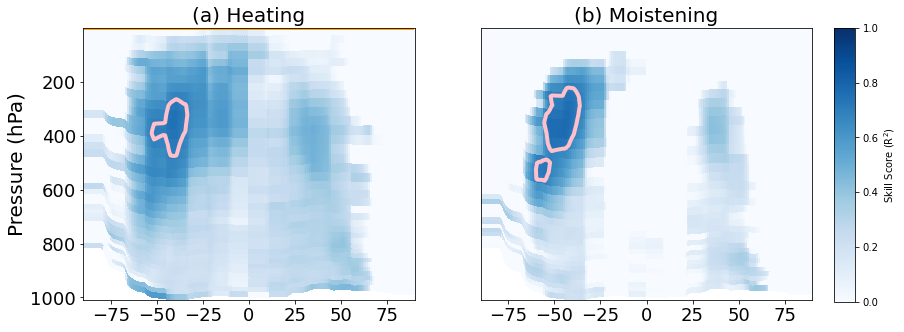

In [22]:
#fig, ax = plt.subplots(2,2, figsize=(15,15))
fig, ax = plt.subplots(1,2, figsize=(15,5))
fz = 20
contour_plot = ax[0].pcolor(XpC, P2_reshape_lat/100, TR2_reshape_lat, cmap = 'Blues', vmin = 0, vmax = 1.0)
ax[0].contour(XpC, P2_reshape_lat/100 , TR2_reshape_lat, [0.7], colors='pink', linewidths=[4])
ax[0].contour(XpC, P2_reshape_lat/100, TR2_reshape_lat, [0.9], colors='orange', linewidths=[4])
ax[0].set_title("(a) Heating", fontsize = fz)
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[0].set_ylabel("Pressure (hPa)", fontsize = fz)
ax[0].locator_params(nbins=8)
ax[0].tick_params(axis='x', labelsize=fz*0.9)
ax[0].tick_params(axis='y', labelsize=fz*0.9)

ax[1].pcolor(XpC, P2_reshape_lat/100, QR2_reshape_lat,  cmap = 'Blues', vmin = 0, vmax = 1.0)
ax[1].contour(XpC, P2_reshape_lat/100, QR2_reshape_lat,  [0.7], colors='pink', linewidths=[4])
ax[1].contour(XpC, P2_reshape_lat/100, QR2_reshape_lat,  [0.9], colors='orange', linewidths=[4])
ax[1].set_title("(b) Moistening", fontsize = fz)
ax[1].set_ylim(ax[1].get_ylim()[::-1])
ax[1].locator_params(nbins=8)
ax[1].set_yticks([])
ax[1].tick_params(axis='x', labelsize=fz*0.9)

#ax[1].yaxis.set_label_coords(-1.38,-0.09)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.02, 0.76])
fig.colorbar(contour_plot, label="Skill Score "+r'$\left(\mathrm{R^{2}}\right)$', cax=cbar_ax)
#plt.suptitle("Trained DNN Skill for Vertically Resolved Tendencies", y = 0.97)
plt.subplots_adjust(hspace=0.13)
print(" ")
plt.savefig('TQTend_Griffin.pdf')
#plt.show()
#plt.savefig("Figures/Figure1.png")

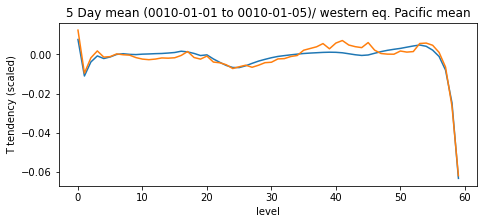

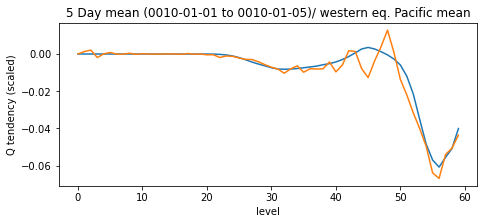

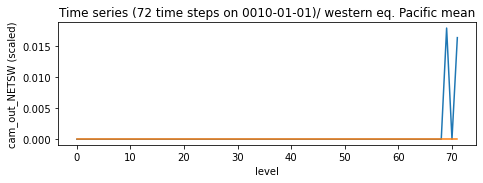

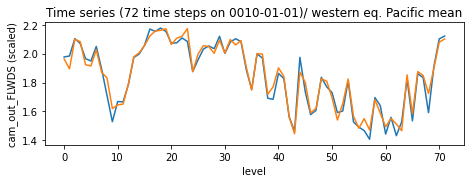

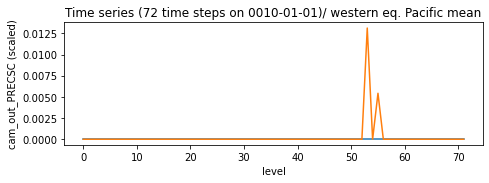

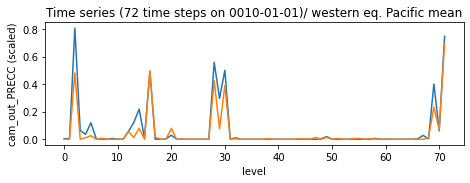

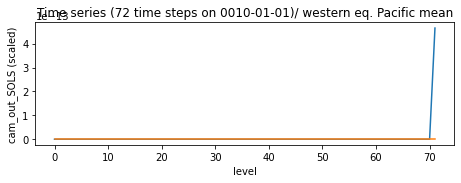

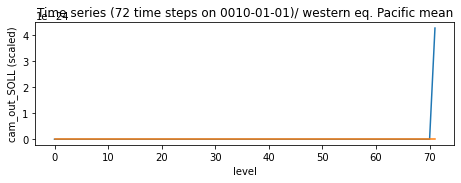

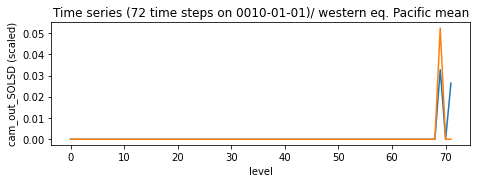

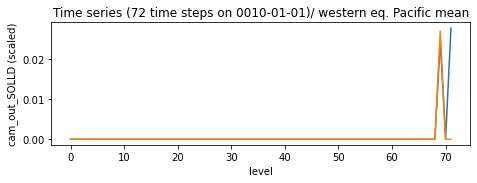

In [23]:
fig, ax = plt.subplots()
y_true_mean_T = np.mean(y_true[:,:60], axis=0)
y_pred_mean_T = np.mean(y_pred[:,:60], axis=0)
ax.plot(y_true_mean_T)
ax.plot(y_pred_mean_T)
ax.set_title('5 Day mean (0010-01-01 to 0010-01-05)/ western eq. Pacific mean')
ax.set_xlabel('level')
ax.set_ylabel('T tendency (scaled)')
fig.set_size_inches(7.5,3)

fig, ax = plt.subplots()
y_true_mean_Q = np.mean(y_true[:,60:120], axis=0)
y_pred_mean_Q = np.mean(y_pred[:,60:120], axis=0)
ax.plot(y_true_mean_Q)
ax.plot(y_pred_mean_Q)
ax.set_title('5 Day mean (0010-01-01 to 0010-01-05)/ western eq. Pacific mean')
ax.set_xlabel('level')
ax.set_ylabel('Q tendency (scaled)')
fig.set_size_inches(7.5,3)

for k, kvar in enumerate(vars_mlo[2:]):
    fig, ax = plt.subplots()
    
    y_true_surface_var = y_true[:,120+k][:72*1]
    y_pred_surface_var = y_pred[:,120+k][:72*1]
    
    ax.plot(y_true_surface_var)
    ax.plot(y_pred_surface_var)
    
    ax.set_title('Time series (72 time steps on 0010-01-01)/ western eq. Pacific mean')
    ax.set_xlabel('level')
    ax.set_ylabel(f'{kvar} (scaled)')
    fig.set_size_inches(7.5,2.25)